In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [3]:
sales = pd.read_csv("../data/train.csv", index_col=[0])
scaler = MinMaxScaler(feature_range=(-1,1))
sales.head()

# sales.drop("Open")


sales=sales.query('Open != 0')

sales=sales.groupby("Date")[["Sales"]].mean()

sales["Sales"]=np.round(sales["Sales"])
scaler.fit(sales.Sales.values.reshape([-1, 1]))
salesScaled = scaler.transform(sales.Sales.values.reshape(-1, 1))
sales['SalesScaled'] = salesScaled

D:\Users\same\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
D:\Users\same\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
window = 45

# # Split 80/20 into train/test data
last = int(len(sales.SalesScaled)/5.0)
Xtrain = sales.SalesScaled[:-last]
Xtest = sales.SalesScaled[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [7]:

from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1],1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer = 'adam', loss = 'mean_squared_error')

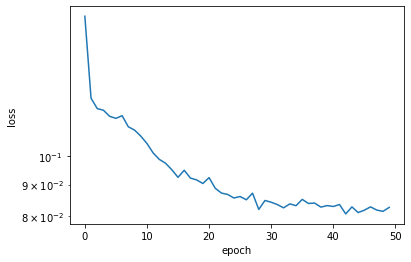

In [8]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs = 50, batch_size = 50,verbose=0)

plt.figure()
plt.ylabel('loss'); plt.xlabel('epoch')
plt.semilogy(history.history['loss'])

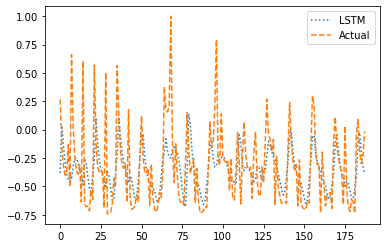

In [9]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window,len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure()
plt.plot(X_pred,':',label='LSTM')
plt.plot(next_X1,'--',label='Actual')
plt.legend()

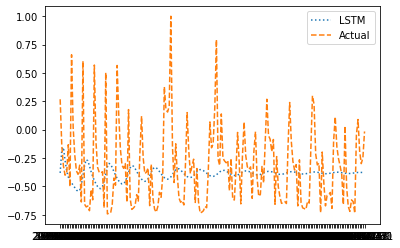

In [12]:
# Using predicted values to predict next step
X_pred = Xtest.copy()
for i in range(window,len(X_pred)):
    xin = X_pred[i-window:i].to_numpy().reshape((1, window, 1))
    X_pred[i] = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure()
plt.plot(X_pred[window:],':',label='LSTM')
plt.plot(next_X1,'--',label='Actual')
plt.legend()